# Math 189 Final Project

> load data and import necesary package below

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso

# Load the TSV file
file_path = 'cape.tsv'
data = pd.read_csv(file_path, sep='\t')
data2 = pd.read_csv('cleaned_WI24_data_with_over_enrollment.csv')

# Display the first few rows of the dataframe
data.head()

,instructor,sub_course,course,term,enroll,evals_made,rcmd_class,rcmd_instr,study_hr_wk,avg_grade_exp,avg_grade_rec
0,"Braswell, Geoffrey E.",ANAR 144,"Pharaohs,Mummies,Pyramds:Egypt",S122,15.0,5.0,80.0,100.0,5.70,3.20,-1.00
1,"Hall, James Ernest",ANBI 134,Human Evolutionary Genetics,S122,14.0,3.0,100.0,100.0,3.83,3.33,-1.00
2,"Hrvoj Mihic, Branka",ANBI 140,Evolution of Human Brain,S122,15.0,4.0,100.0,100.0,6.50,3.25,-1.00
3,"Berman, Michael David",ANSC 122,Language in Society,S122,30.0,8.0,100.0,100.0,3.64,3.83,3.37
4,"Lewis, Leslie R",ANSC 190GS,Medicine&Healing in South Asia,S122,27.0,14.0,100.0,100.0,4.21,4.00,3.99


In [27]:
data2.head()

,subj_course_id,sec_code,sec_id,available,waitlist,total,enrolled_ct,department_name,capacity_utilization
0,AAS 10,A01,303104,1,0,34,33,African American Studies,0.970588
1,AAS 10,A02,303108,0,0,35,35,African American Studies,1.000000
2,AAS 11,A01,303127,3,0,34,31,African American Studies,0.911765
3,AAS 11,A02,303133,6,0,34,28,African American Studies,0.823529
4,AESE 241,A00,301646,2,0,35,33,Aerospace Engineering and Engineering Mechanics,0.942857


## Data Cleaning

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57616 entries, 0 to 57615
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   instructor     57606 non-null  object 
 1   sub_course     57615 non-null  object 
 2   course         57615 non-null  object 
 3   term           57615 non-null  object 
 4   enroll         57615 non-null  float64
 5   evals_made     57615 non-null  float64
 6   rcmd_class     57615 non-null  float64
 7   rcmd_instr     57615 non-null  float64
 8   study_hr_wk    57615 non-null  float64
 9   avg_grade_exp  57615 non-null  float64
 10  avg_grade_rec  57615 non-null  float64
dtypes: float64(7), object(4)
memory usage: 4.8+ MB


> Null value Checking

In [109]:
# Display missing values

# Replace all negative values with NaN in the entire dataframe
data = data.applymap(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)

missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 instructor          10
sub_course           1
course               1
term                 1
enroll               1
evals_made           1
rcmd_class           1
rcmd_instr           1
study_hr_wk          2
avg_grade_exp     1423
avg_grade_rec    16083
dtype: int64


In [97]:
# Fill missing values with a placeholder
# data['instructor'].fillna('Unknown', inplace=True)
# data.fillna(data.mean(), inplace=True)

In [110]:
# Drop rows with missing values
data = data.dropna()

> **Detect and remove outliers** (use 3 standard deviation as the threshold)

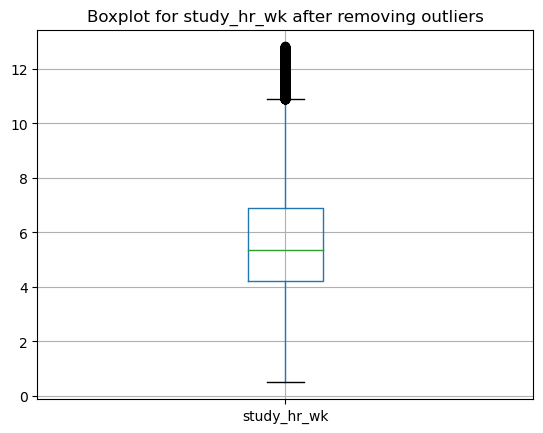

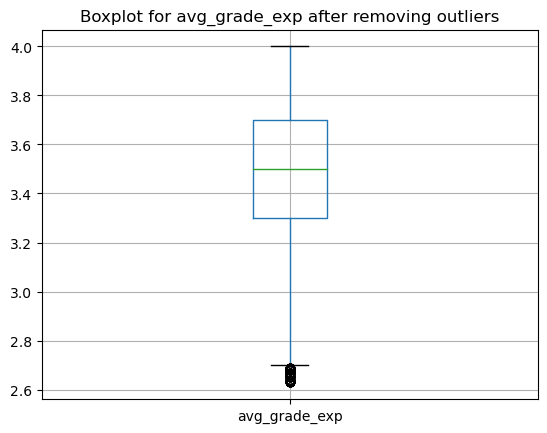


Outliers Removed:
 {'enroll': 627, 'evals_made': 803, 'rcmd_class': 617, 'rcmd_instr': 770, 'study_hr_wk': 496, 'avg_grade_exp': 110, 'avg_grade_rec': 63}


In [111]:
# Remove outliers that are more than three standard deviations away from the mean
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
outliers_removed = {}

# Select one or two columns for boxplots
columns_for_boxplot = ['study_hr_wk', 'avg_grade_exp']  # Example columns

for col in numerical_columns:
    mean = data[col].mean()
    std_dev = data[col].std()
    outliers = (data[col] - mean).abs() > (3 * std_dev)
    outliers_removed[col] = outliers.sum()
    data = data[~outliers]

    if col in columns_for_boxplot:
        # Optionally, visualize the boxplot after outlier removal
        data.boxplot(column=col)
        plt.title(f'Boxplot for {col} after removing outliers')
        plt.show()

# Print the number of outliers removed for each column
print("\nOutliers Removed:\n", outliers_removed)

> Ensure text fields are clean (check and remove possible whitespace existed in text)

In [112]:
whitespace_removed = {}

text_columns = data.select_dtypes(include=['object']).columns
for col in text_columns:
    whitespace_count = data[col].str.count(r'^\s+|\s+$').sum()
    whitespace_removed[col] = whitespace_count
    data[col] = data[col].str.strip()

print("\nWhitespace Removed:\n", whitespace_removed)


Whitespace Removed:
 {'instructor': 0, 'sub_course': 0, 'course': 0, 'term': 0}


## Exploratory Data Analysis (EDA)

> **Histograms** for numerical columns in subplots

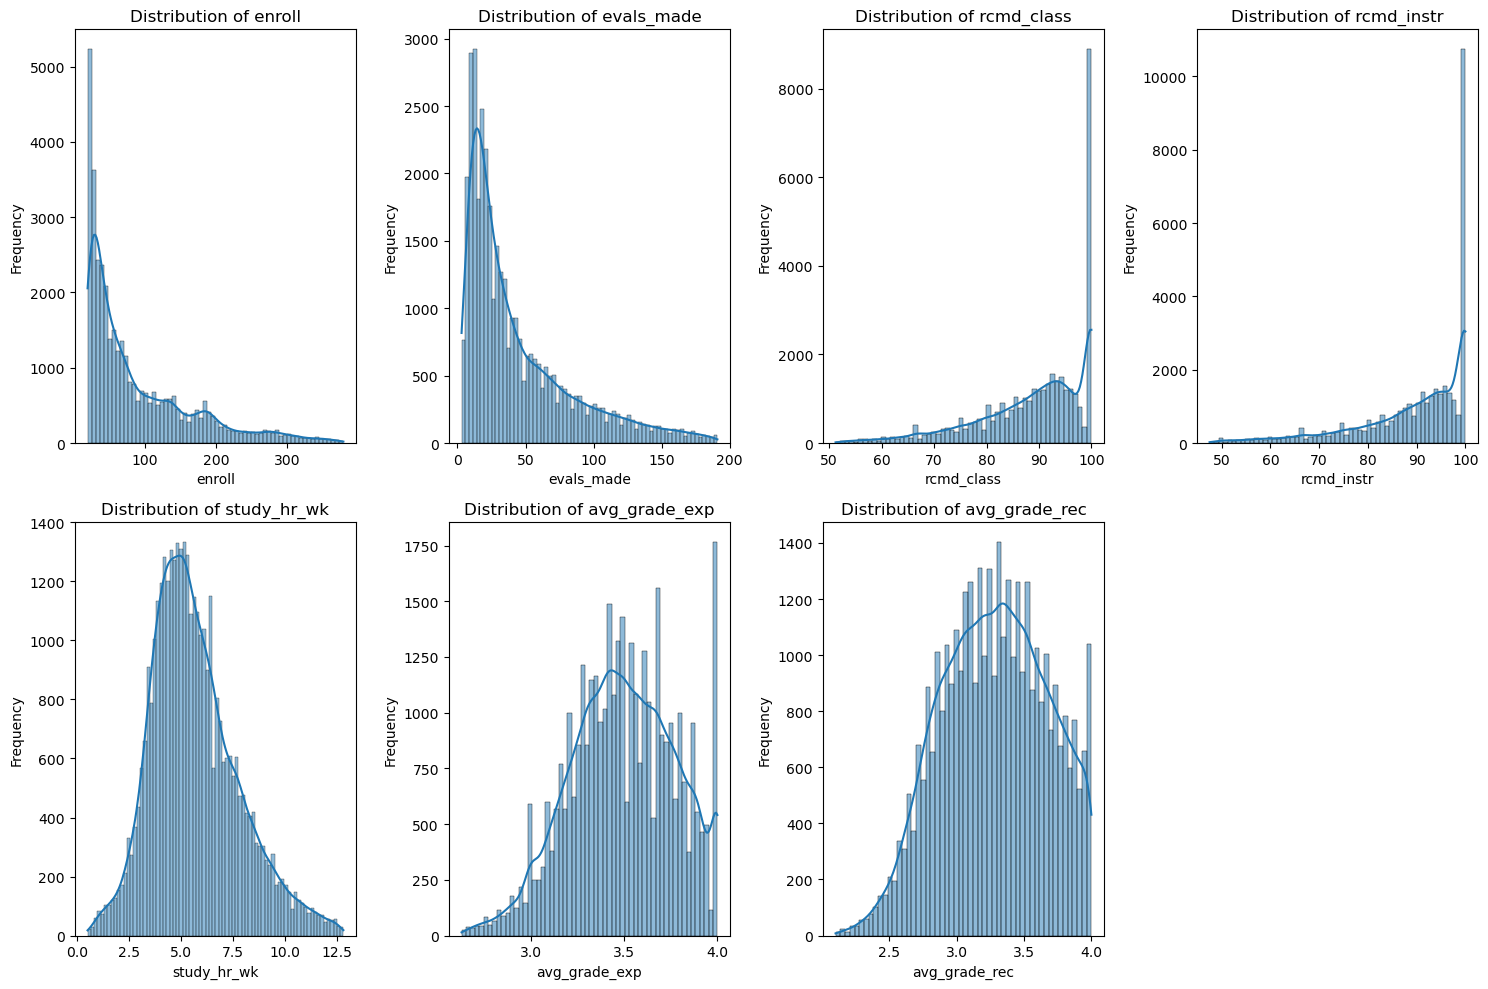

In [114]:
numerical_columns = data.select_dtypes(include=['float64']).columns

n_cols = 4
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(numerical_columns):
    row = i // n_cols
    col_pos = i % n_cols
    sns.histplot(data[col], kde=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

> Correlation matrix

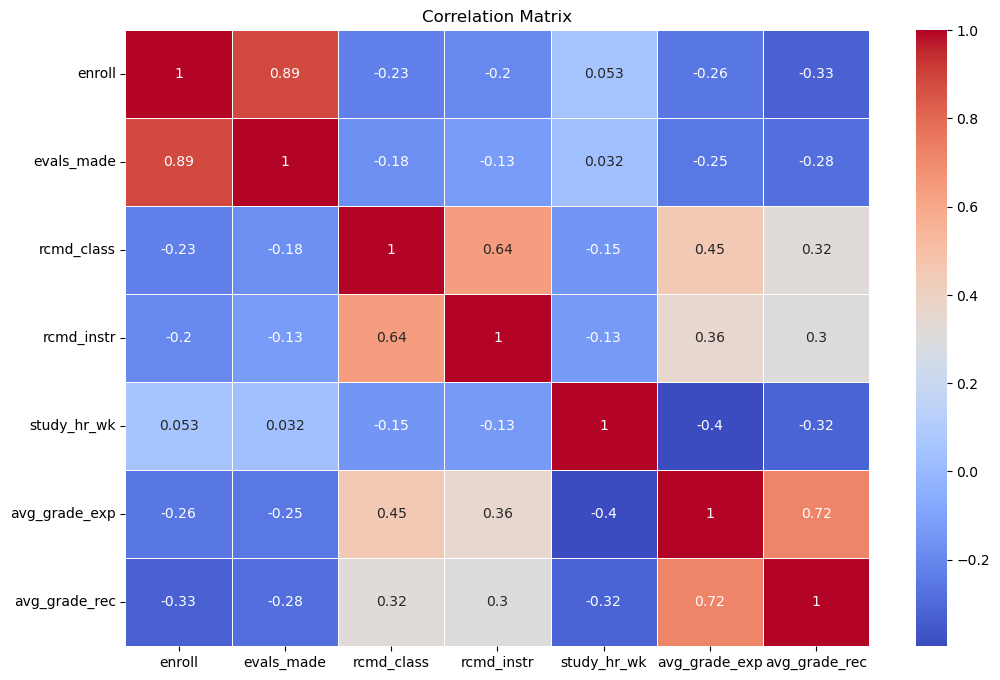

In [115]:
# Compute and visualize the correlation matrix
numerical_columns = data.select_dtypes(include=['float64']).columns
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

> Categorical Analysis

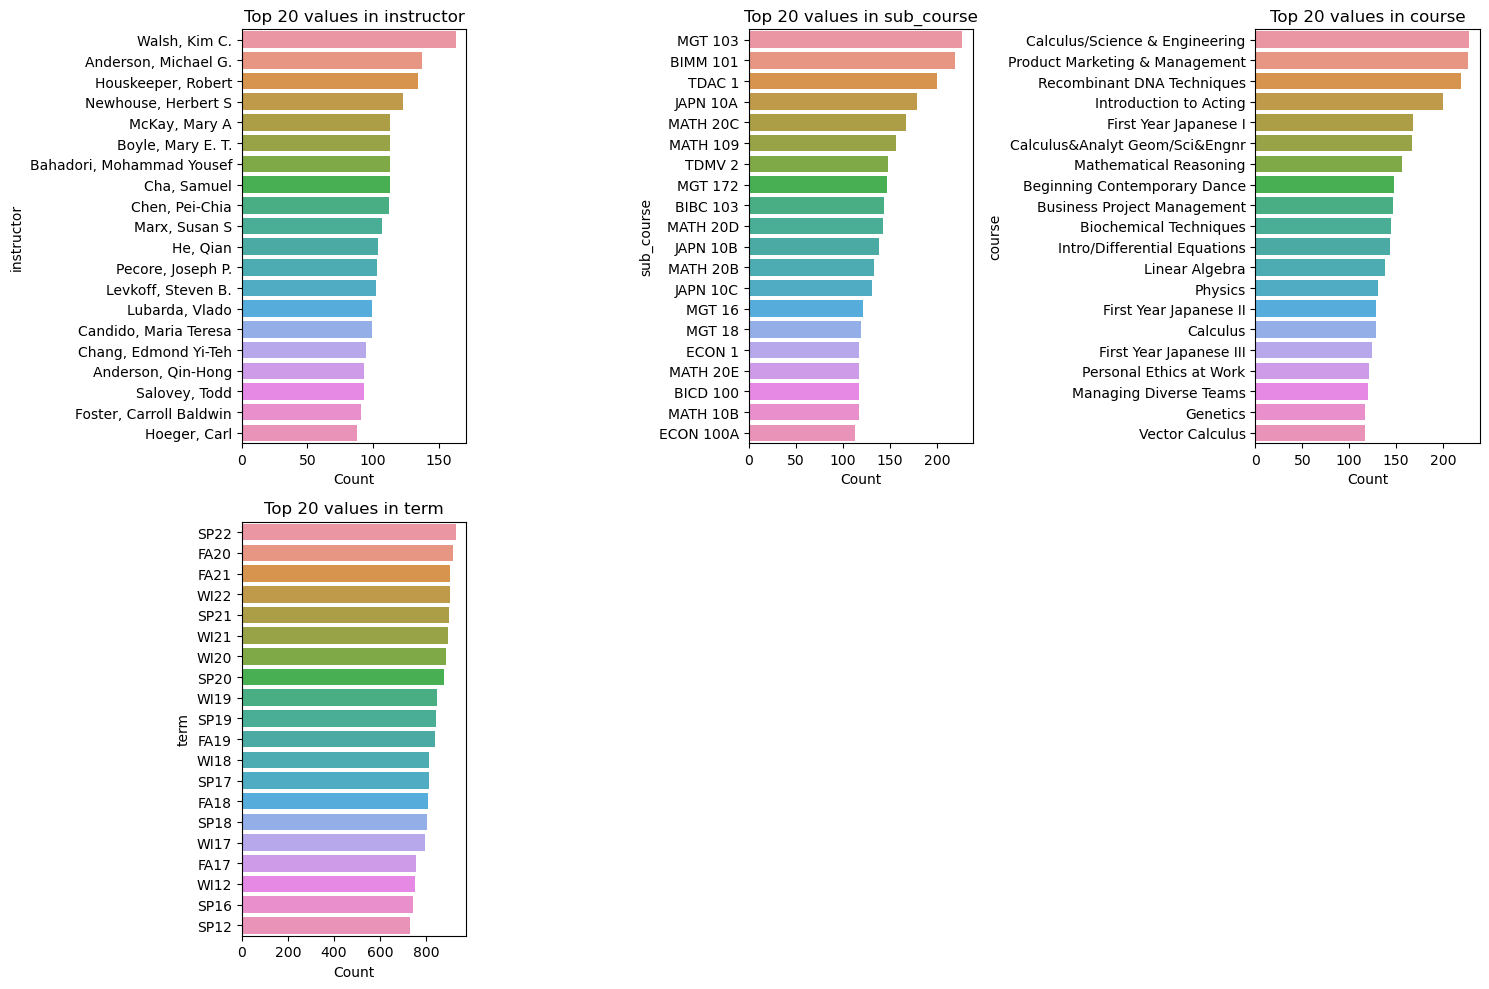

In [116]:
# Count and plot the frequency of unique values in categorical columns using subplots
categorical_columns = data.select_dtypes(include=['object']).columns

n_cols = 3
n_rows = int(np.ceil(len(categorical_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(categorical_columns):
    row = i // n_cols
    col_pos = i % n_cols
    top_values = data[col].value_counts().head(20)
    sns.barplot(y=top_values.index, x=top_values.values, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Top {len(top_values)} values in {col}')
    axes[row, col_pos].set_xlabel('Count')
    axes[row, col_pos].set_ylabel(col)

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

> Pair Plot

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


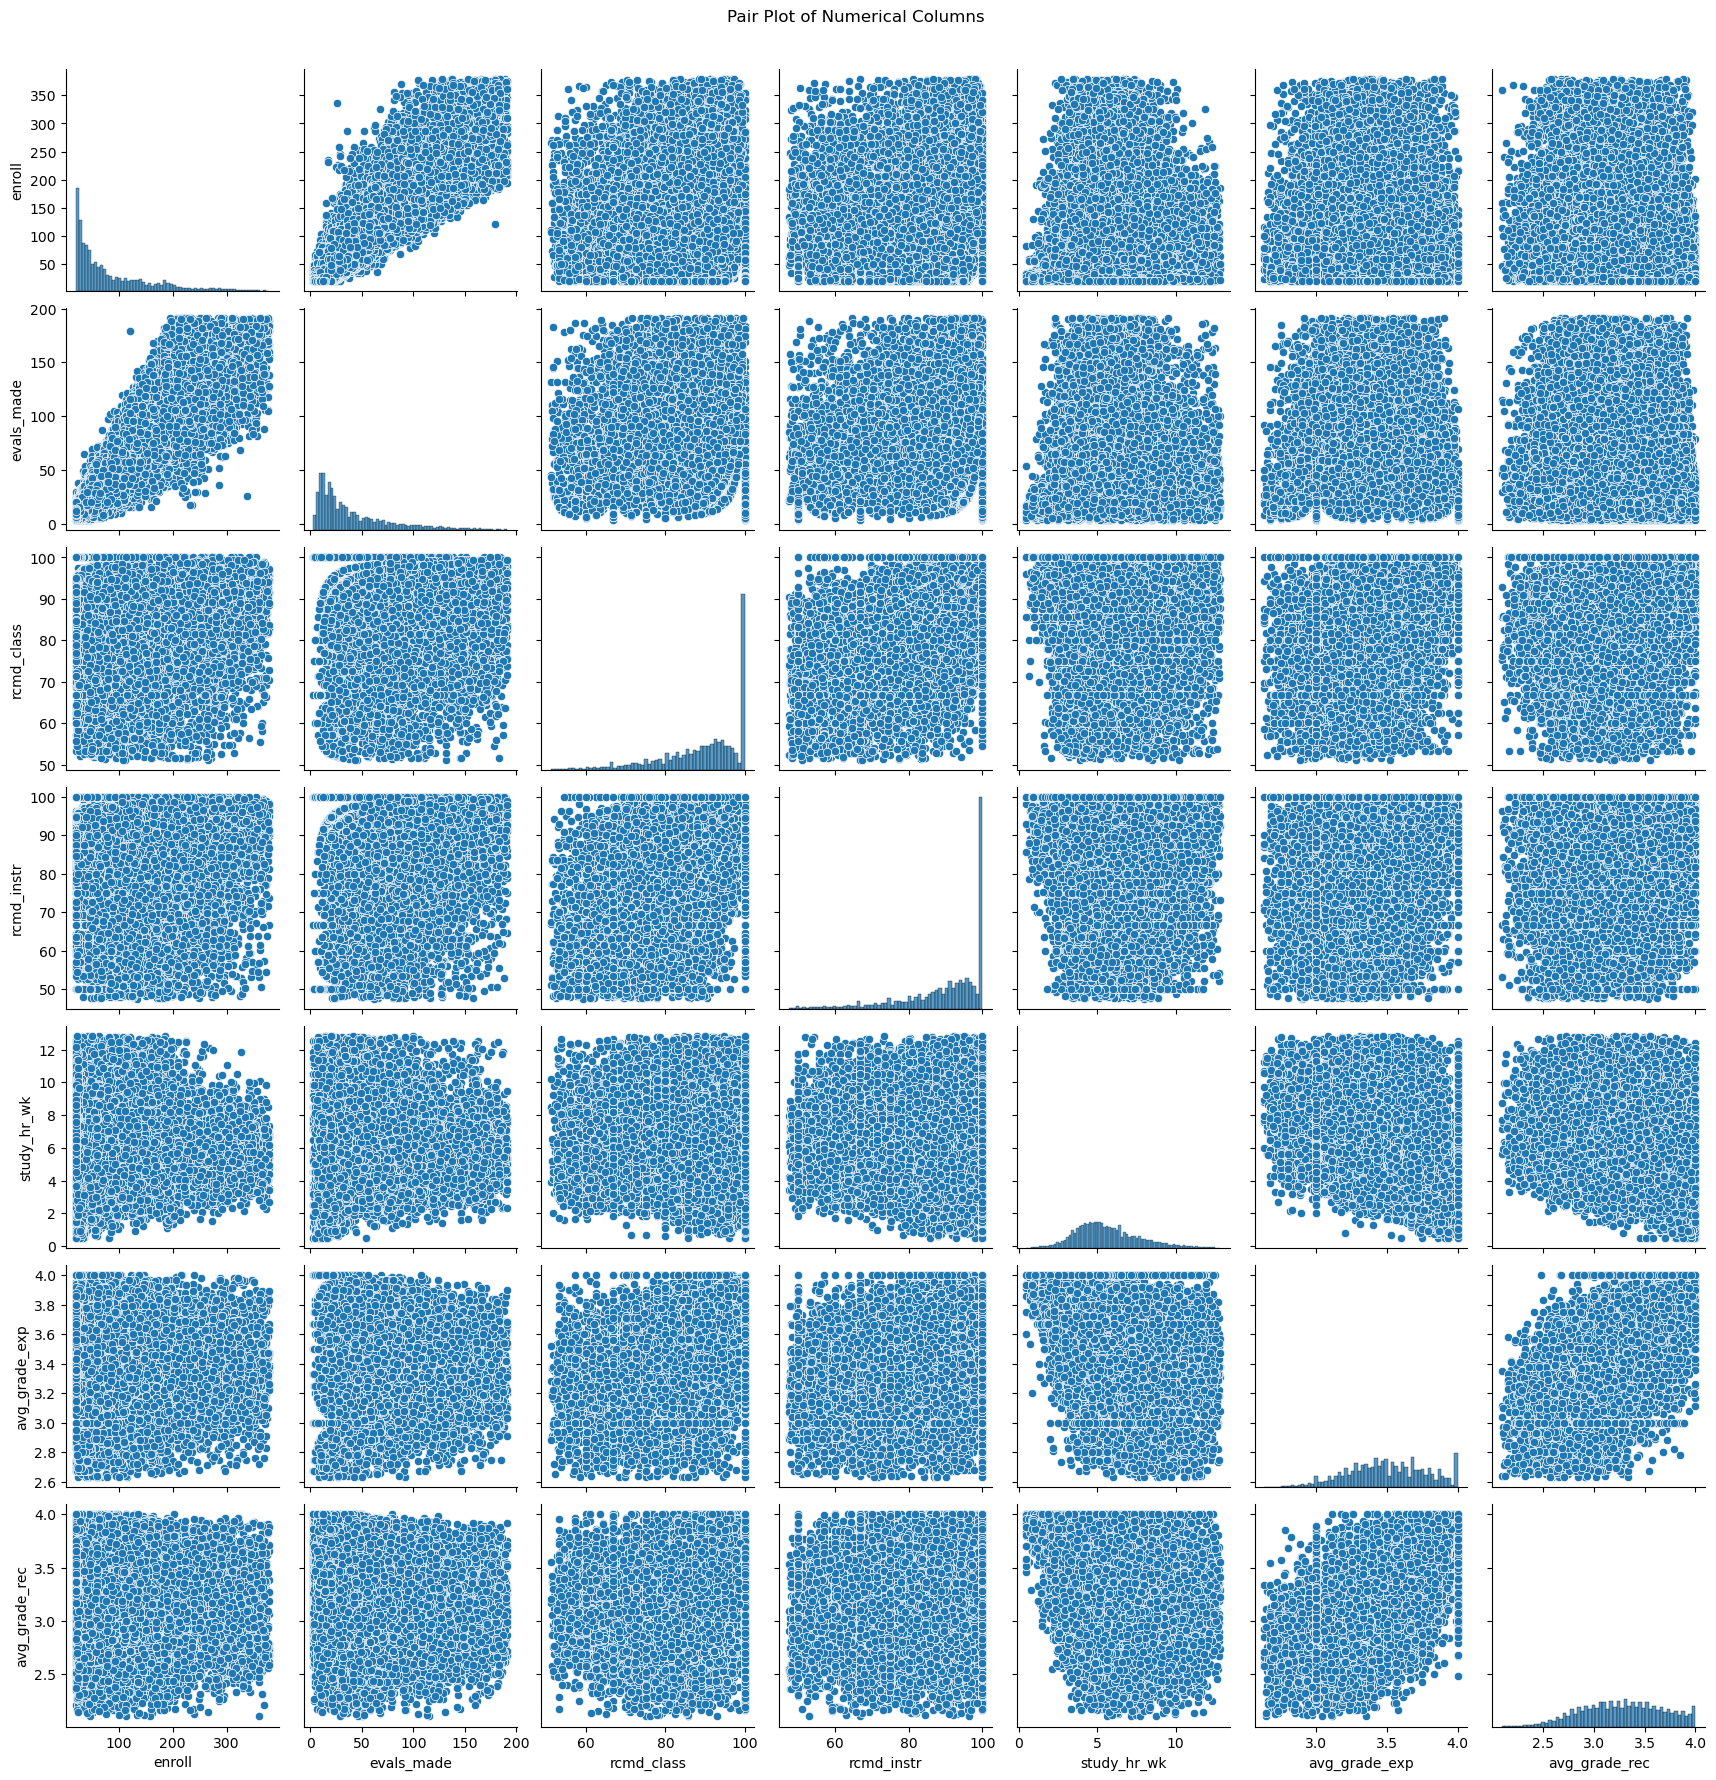

In [117]:
# Create pair plots for numerical columns
sns.pairplot(data[numerical_columns])
plt.suptitle('Pair Plot of Numerical Columns', y=1.02)
plt.show()

## Linear Regression model

In [118]:
# Define the formula
formula = 'avg_grade_rec ~ enroll + evals_made + \
rcmd_class + rcmd_instr + study_hr_wk + avg_grade_exp'

# Fit the linear regression model using the formula
model = smf.ols(formula=formula, data=data).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     7588.
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:21:49   Log-Likelihood:                -3221.0
No. Observations:               37705   AIC:                             6456.
Df Residuals:                   37698   BIC:                             6516.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1353      0.022      6.090

## Assumption checking

> Check for Multicollinearity using VIF

In [119]:
# Define the features
features = ['enroll', 'evals_made', 'rcmd_class', 'rcmd_instr', 'study_hr_wk', 'avg_grade_exp']

# Prepare the feature matrix
X = data[features]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

         Feature         VIF
0         enroll   11.349794
1     evals_made   10.633750
2     rcmd_class  137.523512
3     rcmd_instr  103.754704
4    study_hr_wk    7.192357
5  avg_grade_exp   99.265905


In [120]:
# Define the new set of features by removing 'rcmd_class' and 'rcmd_instr'
features_reduced = ['enroll', 'evals_made', 'study_hr_wk', 'avg_grade_exp']

# Prepare the feature matrix with the reduced set of features
X_reduced = data[features_reduced]

# Calculate VIF for each feature in the reduced set
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(len(X_reduced.columns))]

print(vif_data_reduced)

         Feature        VIF
0         enroll  11.097998
1     evals_made  10.410301
2    study_hr_wk   6.917773
3  avg_grade_exp   7.412271


> Re-test model after using VIF to filter multicolinearity

In [129]:
# Define the formula
formula = 'avg_grade_rec ~ enroll + evals_made + study_hr_wk + avg_grade_exp'

# Fit the linear regression model using the formula
model = smf.ols(formula=formula, data=data).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                 1.123e+04
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:27:16   Log-Likelihood:                -3363.8
No. Observations:               37705   AIC:                             6738.
Df Residuals:                   37700   BIC:                             6780.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1472      0.022      6.830

> Add Interaction and Quadratic Terms

In [130]:
# List of selected features
features_reduced = ['enroll', 'evals_made', 'study_hr_wk', 'avg_grade_exp']

# Add quadratic terms
for feature in features_reduced:
    data[f'{feature}_squared'] = data[feature] ** 2

# Add interaction terms
for feature1, feature2 in itertools.combinations(features_reduced, 2):
    data[f'{feature1}_x_{feature2}'] = data[feature1] * data[feature2]

# Display the first few rows to verify new features
data.head()

,instructor,sub_course,course,term,enroll,evals_made,rcmd_class,rcmd_instr,study_hr_wk,avg_grade_exp,...,enroll_squared,evals_made_squared,study_hr_wk_squared,avg_grade_exp_squared,enroll_x_evals_made,enroll_x_study_hr_wk,enroll_x_avg_grade_exp,evals_made_x_study_hr_wk,evals_made_x_avg_grade_exp,study_hr_wk_x_avg_grade_exp
3,"Berman, Michael David",ANSC 122,Language in Society,S122,30.0,8.0,100.0,100.0,3.64,3.83,...,900.0,64.0,13.2496,14.6689,240.0,109.20,114.90,29.12,30.64,13.9412
4,"Lewis, Leslie R",ANSC 190GS,Medicine&Healing in South Asia,S122,27.0,14.0,100.0,100.0,4.21,4.00,...,729.0,196.0,17.7241,16.0000,378.0,113.67,108.00,58.94,56.00,16.8400
5,"Berman, Michael David",ANTH 1,Introduction to Culture,S122,36.0,16.0,100.0,100.0,4.10,3.79,...,1296.0,256.0,16.8100,14.3641,576.0,147.60,136.44,65.60,60.64,15.5390
6,"Algaze, Guillermo",ANTH 101,Foundations/Social Complexity,S122,32.0,7.0,100.0,100.0,4.79,3.71,...,1024.0,49.0,22.9441,13.7641,224.0,153.28,118.72,33.53,25.97,17.7709
7,"Stewart, Alexander B",ANTH 105,"Climate Change, Race,& Inequal",S122,26.0,6.0,83.3,100.0,5.17,3.40,...,676.0,36.0,26.7289,11.5600,156.0,134.42,88.40,31.02,20.40,17.5780


In [70]:
features_extended = features_reduced + \
                    [f'{feature}_squared' for feature in features_reduced] + \
                    [f'{feature1}_x_{feature2}' for feature1, feature2 in itertools.combinations(features_reduced, 2)]

> Backward feature selection based on BIC criterion

In [123]:
# Define the criterion for BIC
criterion = lambda formula, df: smf.ols(formula, data=df).fit().bic

# Define the remove function
def remove(df, selected_columns, criterion, response='y'):
    worst_criterion = np.inf
    worst_column = None
    for column in selected_columns:
        new_columns = selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

# Define the backward function
def backward(df, criterion, response='y'):
    selected_columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) > 0:
        potential_column, current_criterion = remove(df, selected_columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = selected_columns - {potential_column}
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

In [124]:
# Add the response variable to the DataFrame for backward selection
data_for_backward = data[features_extended + ['avg_grade_rec']]

# Perform backward selection based on BIC
selected_columns = backward(data_for_backward, criterion, response='avg_grade_rec')
print(f'Selected features: {selected_columns}')

Criterion: 4833.746325739043
Criterion: 4826.001706994234
Selected features: {'evals_made_squared', 'evals_made_x_study_hr_wk', 'evals_made', 'study_hr_wk_squared', 'avg_grade_exp_squared', 'enroll_squared', 'study_hr_wk', 'evals_made_x_avg_grade_exp', 'enroll_x_study_hr_wk', 'enroll_x_evals_made', 'enroll', 'avg_grade_exp'}


                            OLS Regression Results                            
Dep. Variable:          avg_grade_rec   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     4124.
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:29:21   Log-Likelihood:                -2344.5
No. Observations:               37705   AIC:                             4715.
Df Residuals:                   37692   BIC:                             4826.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

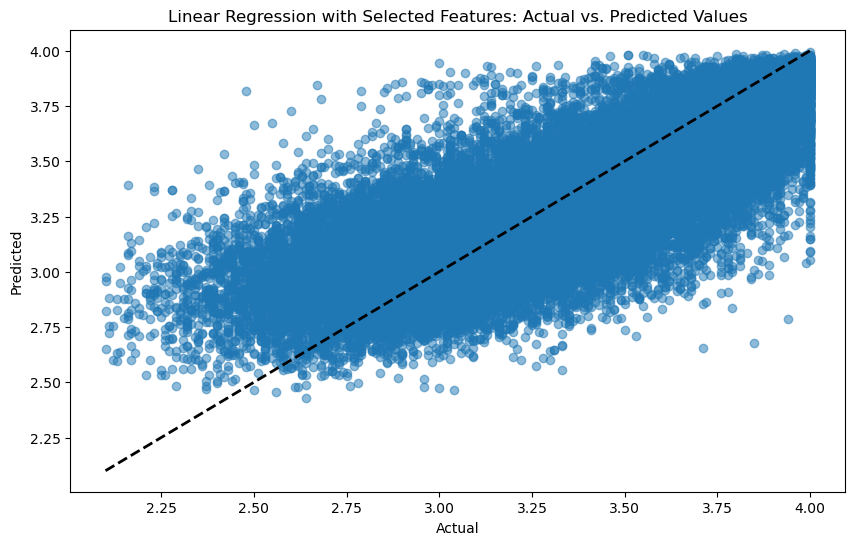

In [132]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the feature matrix and target variable with selected features
X_selected = data[list(selected_columns)]
y = data['avg_grade_rec']

# Add a constant term for the intercept
X_selected = sm.add_constant(X_selected)

# Fit the linear regression model
linear_model = sm.OLS(y, X_selected).fit()

# Print the summary of the linear regression model
print(linear_model.summary())

# Make predictions using the fitted model
linear_predictions = linear_model.predict(X_selected)

# Evaluate the model
linear_mae = np.mean(np.abs(y - linear_predictions))
linear_mse = np.mean((y - linear_predictions) ** 2)
linear_r2 = linear_model.rsquared

print(f'Linear Regression (Selected Features) - MAE: {linear_mae}, MSE: {linear_mse}, R2: {linear_r2}')

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y, linear_predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression with Selected Features: Actual vs. Predicted Values')
plt.show()

In [ ]:
## Proceed with heavier punishment on complexity with regularization

> Perform Ridge/Lasso regression on our model

#### Ridge regression

In [140]:
# Prepare the feature matrix and target variable
X = data[features_extended]
y = data['avg_grade_rec']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)


# Apply Ridge regression
ridge_model = Ridge(alpha=0.6)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate Ridge model
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f'Ridge Regression - MAE: {ridge_mae}, MSE: {ridge_mse}, R2: {ridge_r2}')

Ridge Regression - MAE: 0.20603108061759381, MSE: 0.06769440761654459, R2: 0.571643259837634


#### Lasso regression

In [139]:
# Apply Lasso regression
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)

# Evaluate Lasso model
lasso_mae = mean_absolute_error(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print(f'Lasso Regression - MAE: {lasso_mae}, MSE: {lasso_mse}, R2: {lasso_r2}')

Lasso Regression - MAE: 0.21331234717089256, MSE: 0.07168980248468763, R2: 0.5463611961984374


> Principal Component Analysis

In [150]:
from sklearn.decomposition import PCA

# Prepare the feature matrix and target variable with all features
X = data[features_extended]
y = data['avg_grade_rec']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Number of components: {pca.n_components_}')

Explained variance ratio: [0.58577977 0.2435876  0.10879422 0.03508871]
Number of components: 4


Ridge Regression with PCA - MAE: 0.2104013827914547, MSE: 0.07072164723444857, R2: 0.5431487427146738


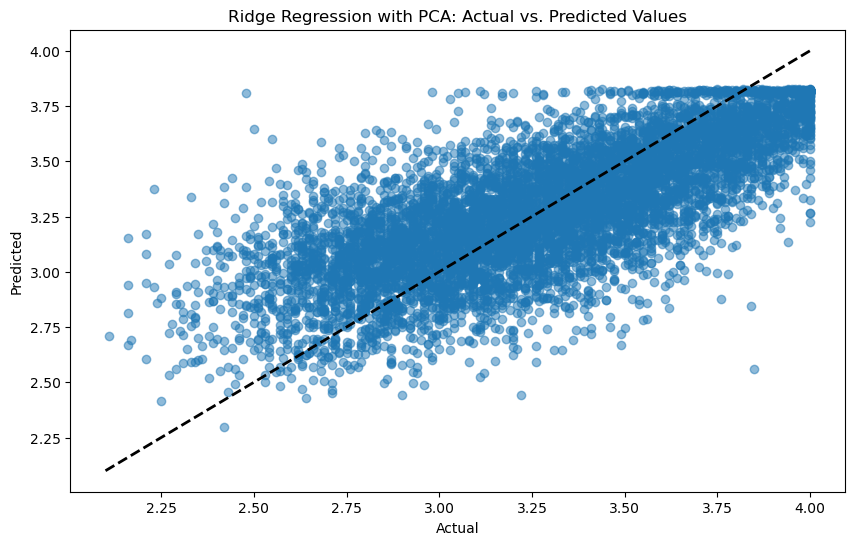

In [154]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Apply Ridge regression
ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate Ridge model
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f'Ridge Regression with PCA - MAE: {ridge_mae}, MSE: {ridge_mse}, R2: {ridge_r2}')

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression with PCA: Actual vs. Predicted Values')
plt.show()